# Graph Algorithms

## Depth first search

The *depth first search* (DFS) is a simply way of traversing a graph, starting from
a given vertex `start`. It can be used
for a number of important problems such as path finding, topological sorting, etc.
It is easiest implemented using recursion. We keep track of visited vertices using
an array of booleans, and the method is applied recursively to all neighbors of
a vertex. Note that this strategy will first traverse an entire branch of a
neighbor node, before continuing to the next neighbor - therefore the name
"depth first".

In [1]:
# Uncomment below if the package is not already installed
#using Pkg; Pkg.add("NBInclude") 

In [2]:
# Import code from previous section
using NBInclude
@nbinclude("Graph_Code.ipynb");

In [3]:
function dfs(g::Graph, start)
    visited = falses(length(g.vertices))
    function visit(ivertex)
        visited[ivertex] = true
        println("Visiting vertex #$ivertex")
        for nb in g.vertices[ivertex].neighbors
            if !visited[nb]
                visit(nb)
            end
        end
    end
    visit(start)
    return nothing
end

dfs (generic function with 1 method)

We can observe the order that the method visits vertices. Note that
this highly depends on the order of the elements in `neighbors`, which
is arbitrary (at least the way we designed it). We will continue to use the graph created in the previous section to demonstrate.

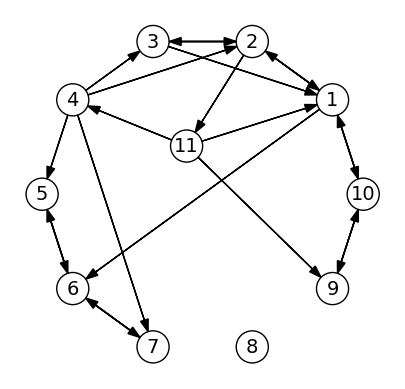

In [4]:
plot(g)

In [5]:
dfs(g,1) 

Visiting vertex #1
Visiting vertex #2
Visiting vertex #3
Visiting vertex #11
Visiting vertex #4
Visiting vertex #5
Visiting vertex #6
Visiting vertex #7
Visiting vertex #9
Visiting vertex #10


### Path finding

A simple application of the DFS method is to find a path between two vertices.
One way to do this is to have the `visit` function return a boolean, indicating
if the final vertex was found on the recursive call or not. If this is `true`,
the current vertex number is added to the list of vertices in the path
(*after* visiting the vertex).

In [6]:
function find_path_dfs(g::Graph, start, finish)
    visited = falses(length(g.vertices))
    path = Int64[]
    function visit(ivertex)
        visited[ivertex] = true
        if ivertex == finish
            pushfirst!(path, ivertex)
            return true
        end
        for nb in g.vertices[ivertex].neighbors
            if !visited[nb]
                if visit(nb)
                    pushfirst!(path, ivertex)
                    return true
                end
            end
        end
        return false
    end
    visit(start)
    return path
end

find_path_dfs (generic function with 1 method)

We also define a simple utility function for plotting paths in a graph:

In [7]:
function plot_path(g, path)
    xypath = [v.coordinates for v in g.vertices][path]
    plot(first.(xypath), last.(xypath), color="red", linewidth=2)
end

plot_path (generic function with 1 method)

and apply the method to out graph from before. Note that this path is again
highly dependent on the order of the `neighbors` array, and in particular it
is in general not the shortest path between the vertices.

Path from 10 to 5: [10, 1, 2, 11, 4, 5]


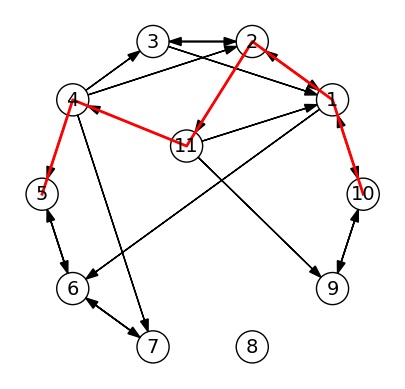

In [8]:
plot(g)
path = find_path_dfs(g, 10, 5)
plot_path(g, path)
println("Path from 10 to 5: $path")

### Other applications of DFS

The DFS method can be used to a number of important graph operations, see below for
examples (from <https://www.geeksforgeeks.org/applications-of-depth-first-search>).

1. For an unweighted graph, DFS traversal of the graph produces the minimum spanning tree and all pair shortest path tree.

2. **Detecting cycle in a graph**: A graph has cycle if and only if we see a back edge during DFS. So we can run DFS for the graph and check for back edges.

3. **Path Finding**: We can specialize the DFS algorithm to find a path between two given vertices u and z.
   - Call DFS(G, u) with u as the start vertex.
   - Use a stack S to keep track of the path between the start vertex and the current vertex.
   - As soon as destination vertex z is encountered, return the path as the
     contents of the stack

4. **Topological Sorting**: Topological Sorting is mainly used for scheduling jobs from the given dependencies among jobs. In computer science, applications of this type arise in instruction scheduling, ordering of formula cell evaluation when recomputing formula values in spreadsheets, logic synthesis, determining the order of compilation tasks to perform in makefiles, data serialization, and resolving symbol dependencies in linkers.

5. To test if a graph is **bipartite**: We can augment either BFS or DFS when we first discover a new vertex, color it opposited its parents, and for each other edge, check it doesn’t link two vertices of the same color. The first vertex in any connected component can be red or black!

6. Finding **Strongly Connected Components** of a graph: A directed graph is called strongly connected if there is a path from each vertex in the graph to every other vertex.
   
7. Solving **puzzles with only one solution**, such as mazes. (DFS can be adapted to find all solutions to a maze by only including nodes on the current path in the visited set.)

## Breadth first search

An alternative way to traverse a graph is the *Breadth First Search* (BFS) method,
which visits all of the neighbor vertices at the present depth before moving on to
the vertices at the next depth level. This is easiest implemented in a non-recursive
way, using a *queue*, which can be seen as an array where new elements are added to
the end but elements are extracted from the beginning ("First-In-First-Out", or FIFO).

In [9]:
function bfs(g::Graph, start)
    visited = falses(length(g.vertices))
    S = [start]
    visited[start] = true
    while !isempty(S)
        ivertex = popfirst!(S)
        println("Visiting vertex #$ivertex")
        for nb in g.vertices[ivertex].neighbors
            if !visited[nb]
                visited[nb] = true
                push!(S, nb)
            end
        end
    end
end

bfs (generic function with 1 method)

Running the function of the previous graph, we note that the order
is very different from the DFS method:

In [10]:
bfs(g,1)

Visiting vertex #1
Visiting vertex #2
Visiting vertex #10
Visiting vertex #6
Visiting vertex #3
Visiting vertex #11
Visiting vertex #9
Visiting vertex #7
Visiting vertex #5
Visiting vertex #4


### Shortest path

The BFS method has the property that it will visit the vertices in an order
that corresponds to a *shortest path* from the starting vertex to each other
vertex (that is, fewest number of edges). This is important for many
applications, and we can modify our BFS method to return this path.

Instead of simply keeping track of the visited nodes, we use an array
`parent` which is inially zero for each vertex. After visiting a new
vertex, `parent` is set to the vertex number of the vertex it came
from. This means we can trace the (shortest) path from any vertex
back to the starting vertex, and build the path.

In [11]:
function shortest_path_bfs(g::Graph, start, finish)
    parent = zeros(Int64, length(g.vertices))
    S = [start]
    parent[start] = start
    while !isempty(S)
        ivertex = popfirst!(S)
        if ivertex == finish
            break
        end
        for nb in g.vertices[ivertex].neighbors
            if parent[nb] == 0 # Not visited yet
                parent[nb] = ivertex
                push!(S, nb)
            end
        end
    end
    # Build path
    path = Int64[]
    iv = finish
    while true
        pushfirst!(path, iv)
        if iv == start
            break
        end
        iv = parent[iv]
    end
    return path
end


shortest_path_bfs (generic function with 1 method)

Shortest path from 10 to 5: [10, 1, 6, 5]


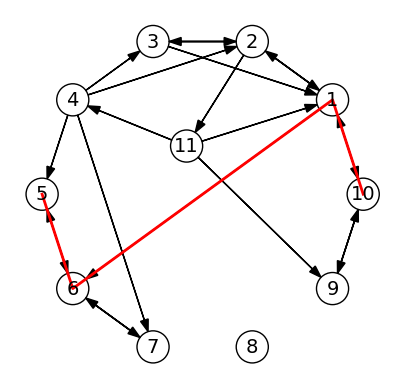

In [12]:
path = shortest_path_bfs(g, 10, 5)
plot(g)
plot_path(g, path)
println("Shortest path from 10 to 5: $path")

### Shortest path application: Optimal trajectory

Here we consider navigation on a grid, with the goal of reaching a destination
with the fewest possible moves. Any neighbor in the grid can be reached in one
move, unless there is a wall. This can be represented as a grid, with edges
between vertices with admissible moves.

As an example, we draw an "obstacle course" and create a graph that represents it:

In [13]:
field = """
....O....
O.O.O.O..
..O...O.O
.OOOOOO.O
....OO..O
.O...OOOO
.O.......
.OOOOOO..
......O..
......O..
"""
n = 10

F = Int.(reverse(reshape(collect(field), n, n) .== 'O', dims=2))

g1 = Graph([])
nbr = 0
for j = 1:n
    for i = 1:n
        nbr += 1
        nb = Int64[]
        for dj = -1:1
            for di = -1:1
                if 1 ≤ i+di ≤ n && 1 ≤ j+dj ≤ n
                    if F[i,j] == 0 && F[i+di,j+dj] == 0
                        push!(nb, nbr + di + n*dj)
                    end
                end
            end
        end
        v = Vertex(nb, coordinates=[i,j])
        push!(g1.vertices, v)
    end
end

The shortest path algorithm can now find the optimal trajectory:

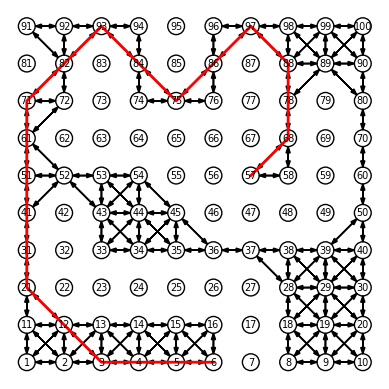

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f189ef76e10>

In [14]:
path = shortest_path_bfs(g1, 6, 57)
xypath = [v.coordinates for v in g1.vertices][path]
plot(g1, scale=0.5)
plot(first.(xypath), last.(xypath), color="red", linewidth=2)

### Other applications of BFS

Like the DFS method, the BFS method is also very important for a wide range of graph
algorithms. See below for
examples (from <https://www.geeksforgeeks.org/applications-of-breadth-first-traversal>).

1) **Shortest Path and Minimum Spanning Tree for unweighted graph**: In an unweighted graph, the shortest path is the path with least number of edges. With Breadth First, we always reach a vertex from given source using the minimum number of edges. Also, in case of unweighted graphs, any spanning tree is Minimum Spanning Tree and we can use either Depth or Breadth first traversal for finding a spanning tree.

2) **Peer to Peer Networks**: In Peer to Peer Networks like BitTorrent, Breadth First Search is used to find all neighbor nodes.

3) **Crawlers in Search Engines**: Crawlers build index using Breadth First. The idea is to start from source page and follow all links from source and keep doing same. Depth First Traversal can also be used for crawlers, but the advantage with Breadth First Traversal is, depth or levels of the built tree can be limited.

4) **Social Networking Websites**: In social networks, we can find people within a given distance ‘k’ from a person using Breadth First Search till ‘k’ levels.

5) **GPS Navigation systems**: Breadth First Search is used to find all neighboring locations.

6) **Broadcasting in Network**: In networks, a broadcasted packet follows Breadth First Search to reach all nodes.

7) **In Garbage Collection**: Breadth First Search is used in copying garbage collection using Cheney’s algorithm. Refer this and for details. Breadth First Search is preferred over Depth First Search because of better locality of reference:

8) **Cycle detection in undirected graph**: In undirected graphs, either Breadth First Search or Depth First Search can be used to detect cycle. In directed graph, only depth first search can be used.

9) **Ford–Fulkerson algorithm**: In Ford-Fulkerson algorithm, we can either use Breadth First or Depth First Traversal to find the maximum flow. Breadth First Traversal is preferred as it reduces worst case time complexity to O(VE2).

10) **To test if a graph is Bipartite**: We can either use Breadth First or Depth First Traversal.

11) **Path Finding**: We can either use Breadth First or Depth First Traversal to find if there is a path between two vertices.

12) **Finding all nodes within one connected component**: We can either use Breadth First or Depth First Traversal to find all nodes reachable from a given node.